In [1]:
##%matplotlib widget
%matplotlib notebook

This notebook is a second attempt to add $ (x,y)_{max} $ position information to the input feature set perturbativly.

This is done use a FourFeature model that has the same architecture as the TwoFeature 6 convolutional layer model.
The differences/similarlities are:

  [1]  the FourFeature model has four channels of input rather than two.
  [2]  the extra two channels are added by using load_xy=True in collect_data (x2)
  [3]  the pretrained_dict is used with strict=
  
In the first iterations, the weights from a trained TwoFeature_CNN6Layer_A model should be reused for the (X,Xsq) part of the algorithm, and the algorithm should only learn the filter for the (perturbative) (x,y) features.
  
Once the perturbative filters are beng generated, the algorithm can start with weights from a previous iteration of this algorithm and all weights free to float.

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Thu Aug 15 11:30:59 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.40.04    Driver Version: 418.40.04    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   31C    P8    23W / 250W |      0MiB / 12036MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   34C    P0    32W / 250W |   1457MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

## added 190723
!pip install torchsummary
from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 100

# Name is the output file name

##oldName = 'July18_XandXsq_CNN6Layer_D15_YetAnother600epochs_160K_lr_1em4_bs64_Alt_Loss_A_3p0'
## = 'July24_FourFeature_CNN6Layer_D15_First20epochs_160K_lr_3em5_bs64_Alt_Loss_A_3p0'
##oldName = 'July25_FourFeature_CNN6Layer_D15_First20epochs_240K_lr_1em3_bs64_Alt_Loss_A_3p0_pert'
oldName = 'Aug10_FourFeature_CNN6LayerPlus_TargetsA_First400epochs_160K_lr_1em3_bs64_Alt_Loss_A_3p0'

##  190810  mds
folder = 'Aug15_FourFeature_CNN6LayerPlus_TargetsAA_Another100epochs_160K_lr_3em4_bs128_Alt_Loss_A_4p5'
name = 'Aug15_FourFeature_CNN6LayerPlus_TargetsAA_Another100epochs_160K_lr_3em4_bs128_Alt_Loss_A_4p5'

# Make an output folder named "name" (change if you want)
folder = 'ML/' + folder
output = Path(folder)


oldOutput = Path(oldName)

# Size of batches
batch_size = 128

# How fast to learn
learning_rate = 3e-4

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below


from model.models_mds_E import FourFeature_CNN6Layer_D as Model

from model.training import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(0)

1 available GPUs (initially using device 0):
  0 TITAN V


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [9]:
## newer vernacular
# Training dataset. You can put as many files here as desired.

##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('dataAA/Aug14_80K_train.h5',
                            'dataAA/Oct03_80K_train.h5',
##                            'dataA/Oct03_80K2_train.h5',
                            batch_size=batch_size,
##                           device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=True,
                            load_xy=True)

# Validation dataset. You can slice to reduce the size.
val_loader = collect_data('dataAA/Oct03_20K_val.h5',
                          batch_size=batch_size,
                          slice=slice(256 * 39),
##                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=True,
                          load_xy=True)

Loading data...
Loaded dataAA/Aug14_80K_train.h5 in 25.4 s
Loaded dataAA/Oct03_80K_train.h5 in 25.95 s
Constructing 160000 event dataset took 8.96 s
Loading data...
Loaded dataAA/Oct03_20K_val.h5 in 5.65 s
Constructing 9984 event dataset took 0.6546 s


In [10]:
##debug

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [11]:
model = Model()

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
loss = Loss(epsilon=1e-5,coefficient=4.5)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

ct, child =  0    Conv1d(2, 25, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  1    Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  2    Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  3    Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  4    Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child =  5    Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
ct, child =  6    Conv1d(2, 10, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  7    Conv1d(10, 5, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  8    Conv1d(5, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child =  9    Linear(in_features=4000, out_features=4000, bias=True)
ct, child =  10    Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
ct, child =  11    Dropout(p=0.15)
ct, child =  12    Dropout(p=0.15)
ct, child =  13    Dropout(p=0.15)
ct, child =  14    Dropout(p=0.15)
ct, 

In [12]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

In [13]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##pretrained_dict = torch.load('./July19_XandXsq_CNN5Layer_D15_First40epochs_160K_lr_1em4_bs64_Alt_Loss_A_3p0/July19_XandXsq_CNN5Layer_D15_First40epochs_160K_lr_1em4_bs64_Alt_Loss_A_3p0_final.pyt')
##  epoch 396 chosen as starting point as it had the lowests training sample cost in the lasst 10 epochs
pretrained_dict = torch.load('./ML/Aug14_FourFeature_CNN6LayerPlus_TargetsAA_400epochs_160K_lr_3em4_bs64_Alt_Loss_A_4p5/Aug14_FourFeature_CNN6LayerPlus_TargetsAA_400epochs_160K_lr_3em4_bs64_Alt_Loss_A_4p5_final.pyt')
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
    
print(" \n","  for pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
## mds  

print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
## print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict
##model.load_state_dict(pretrained_dict,strict=False)
model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)


output =  ML/Aug15_FourFeature_CNN6LayerPlus_TargetsAA_Another100epochs_160K_lr_3em4_bs128_Alt_Loss_A_4p5
for model_dict
index, k =   0    conv1.weight
index, k =   1    conv1.bias
index, k =   2    conv2.weight
index, k =   3    conv2.bias
index, k =   4    conv3.weight
index, k =   5    conv3.bias
index, k =   6    conv4of6.weight
index, k =   7    conv4of6.bias
index, k =   8    conv5of6.weight
index, k =   9    conv5of6.bias
index, k =   10    finalFilter.weight
index, k =   11    finalFilter.bias
index, k =   12    ppConv1.weight
index, k =   13    ppConv1.bias
index, k =   14    ppConv2.weight
index, k =   15    ppConv2.bias
index, k =   16    ppConv3.weight
index, k =   17    ppConv3.bias
index, k =   18    ppFc1.weight
index, k =   19    ppFc1.bias
index, k =   20    ppFinalFilter.weight
index, k =   21    ppFinalFilter.bias
 
   for pretrained_dict
index, k =   0    conv1.weight
index, k =   1    conv1.bias
index, k =   2    conv2.weight
index, k =   3    conv2.bias
index, k =

In [14]:
model = model.to(device)

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


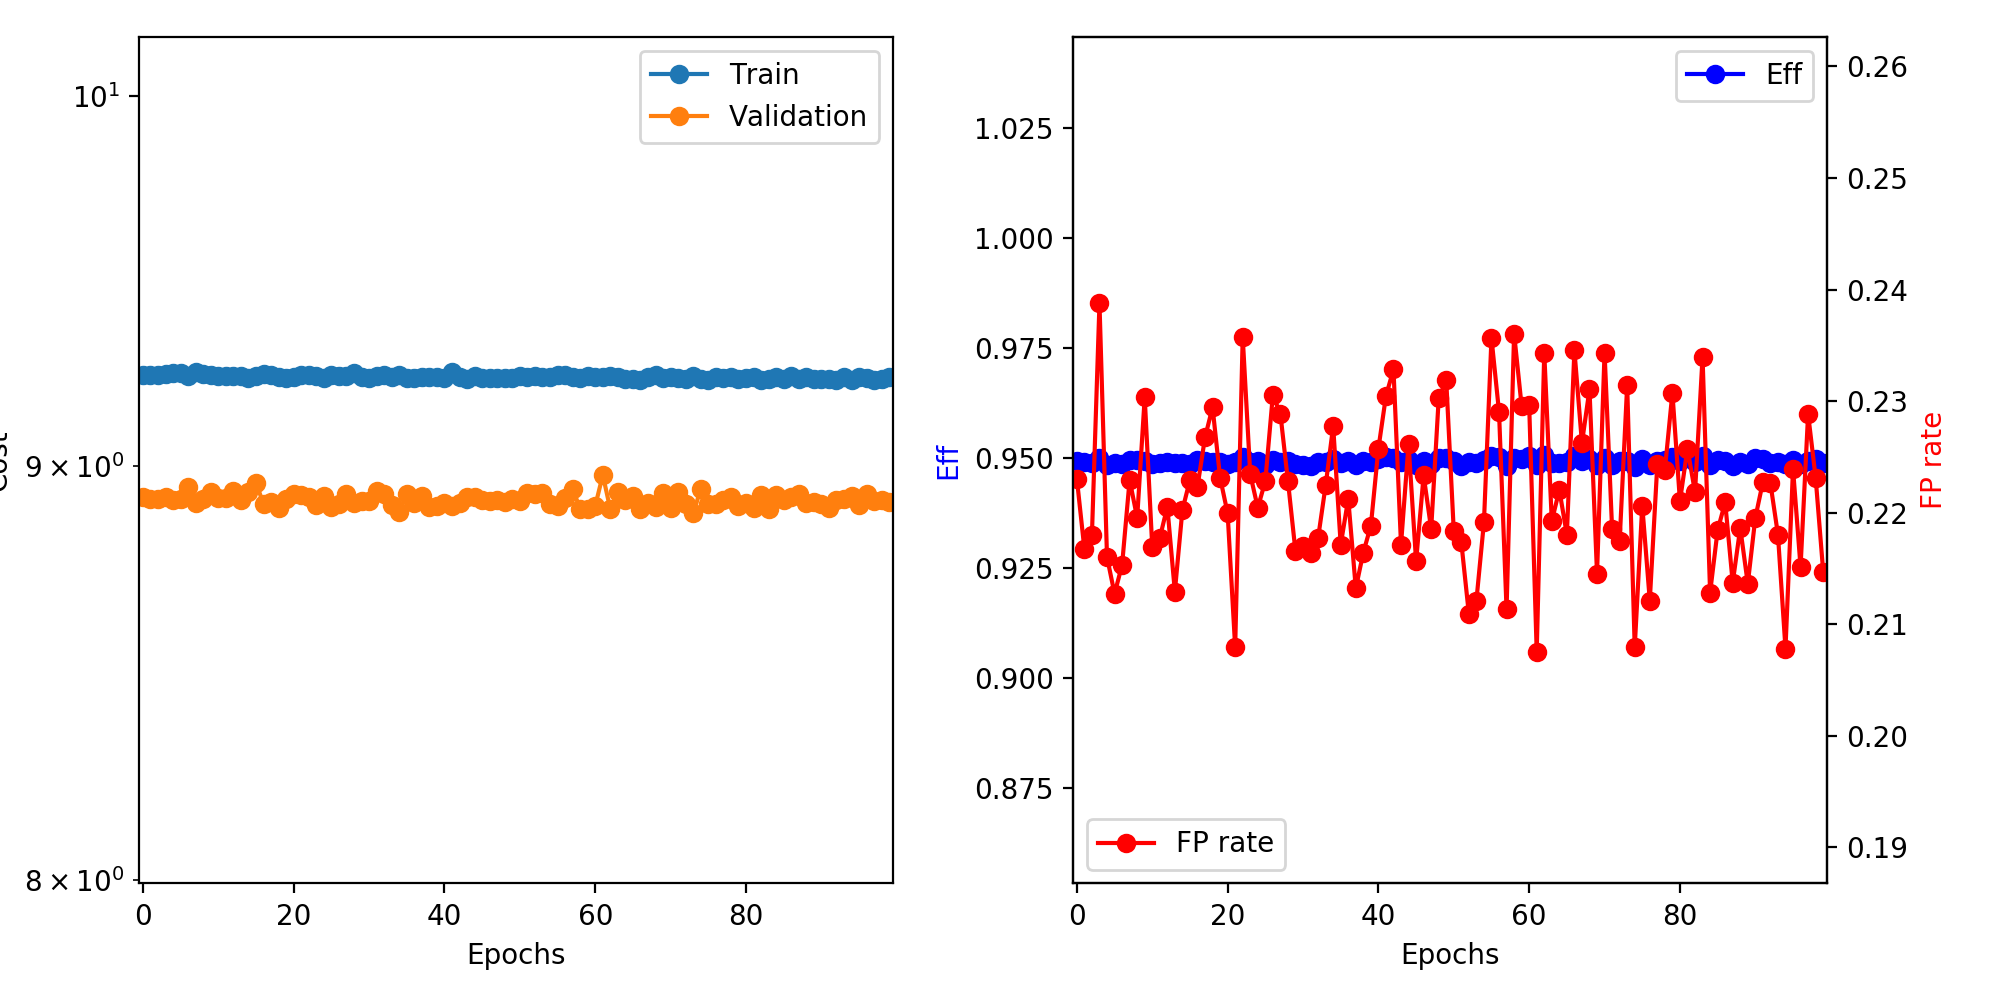

In [15]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [16]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)
    
    replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
    replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 1250, val = 78


Epoch 0: train=9.23694, val=8.92224, took 77.72 s
  Validation Found 51747 of 54504, added 2227 (eff 94.94%) (0.223 FP/event)


Epoch 1: train=9.2383, val=8.91702, took 77.119 s
  Validation Found 51734 of 54504, added 2164 (eff 94.92%) (0.217 FP/event)


Epoch 2: train=9.2368, val=8.91719, took 75.869 s
  Validation Found 51719 of 54504, added 2177 (eff 94.89%) (0.218 FP/event)


Epoch 3: train=9.23891, val=8.92243, took 76.371 s
  Validation Found 51780 of 54504, added 2384 (eff 95.00%) (0.239 FP/event)


Epoch 4: train=9.24158, val=8.91528, took 75.709 s
  Validation Found 51697 of 54504, added 2157 (eff 94.85%) (0.216 FP/event)


Epoch 5: train=9.24152, val=8.91656, took 75.687 s
  Validation Found 51717 of 54504, added 2124 (eff 94.89%) (0.213 FP/event)


Epoch 6: train=9.23575, val=8.94779, took 75.536 s
  Validation Found 51702 of 54504, added 2150 (eff 94.86%) (0.215 FP/event)


Epoch 7: train=9.24583, val=8.9061, took 75.417 s
  Validation Found 51756 of 54504, added 2226 (eff 94.96%) (0.223 FP/event)


Epoch 8: train=9.23896, val=8.91675, took 75.355 s
  Validation Found 51759 of 54504, added 2192 (eff 94.96%) (0.22 FP/event)


Epoch 9: train=9.23661, val=8.93415, took 75.277 s
  Validation Found 51741 of 54504, added 2300 (eff 94.93%) (0.23 FP/event)


Epoch 10: train=9.23343, val=8.91933, took 75.271 s
  Validation Found 51700 of 54504, added 2166 (eff 94.86%) (0.217 FP/event)


Epoch 11: train=9.23485, val=8.91914, took 75.439 s
  Validation Found 51721 of 54504, added 2174 (eff 94.89%) (0.218 FP/event)


Epoch 12: train=9.23414, val=8.93798, took 75.467 s
  Validation Found 51734 of 54504, added 2202 (eff 94.92%) (0.221 FP/event)


Epoch 13: train=9.23546, val=8.9133, took 75.459 s
  Validation Found 51721 of 54504, added 2126 (eff 94.89%) (0.213 FP/event)


Epoch 14: train=9.23047, val=8.93465, took 75.418 s
  Validation Found 51722 of 54504, added 2199 (eff 94.90%) (0.22 FP/event)


Epoch 15: train=9.23555, val=8.95771, took 75.44 s
  Validation Found 51707 of 54504, added 2226 (eff 94.87%) (0.223 FP/event)


Epoch 16: train=9.23953, val=8.90375, took 75.369 s
  Validation Found 51756 of 54504, added 2220 (eff 94.96%) (0.222 FP/event)


Epoch 17: train=9.23753, val=8.90929, took 75.301 s
  Validation Found 51744 of 54504, added 2264 (eff 94.94%) (0.227 FP/event)


Epoch 18: train=9.23296, val=8.8949, took 75.428 s
  Validation Found 51734 of 54504, added 2291 (eff 94.92%) (0.229 FP/event)


Epoch 19: train=9.23045, val=8.91557, took 75.423 s
  Validation Found 51730 of 54504, added 2228 (eff 94.91%) (0.223 FP/event)


Epoch 20: train=9.23155, val=8.92844, took 75.432 s
  Validation Found 51707 of 54504, added 2196 (eff 94.87%) (0.22 FP/event)


Epoch 21: train=9.23613, val=8.92807, took 75.406 s
  Validation Found 51724 of 54504, added 2076 (eff 94.90%) (0.208 FP/event)


Epoch 22: train=9.23821, val=8.92122, took 75.433 s
  Validation Found 51785 of 54504, added 2354 (eff 95.01%) (0.236 FP/event)


Epoch 23: train=9.23582, val=8.90136, took 75.43 s
  Validation Found 51735 of 54504, added 2231 (eff 94.92%) (0.223 FP/event)


Epoch 24: train=9.22953, val=8.92456, took 75.451 s
  Validation Found 51744 of 54504, added 2201 (eff 94.94%) (0.22 FP/event)


Epoch 25: train=9.23704, val=8.89569, took 75.503 s
  Validation Found 51695 of 54504, added 2225 (eff 94.85%) (0.223 FP/event)


Epoch 26: train=9.23538, val=8.90392, took 75.433 s
  Validation Found 51758 of 54504, added 2302 (eff 94.96%) (0.231 FP/event)


Epoch 27: train=9.23427, val=8.92961, took 75.503 s
  Validation Found 51733 of 54504, added 2285 (eff 94.92%) (0.229 FP/event)


Epoch 28: train=9.24212, val=8.90633, took 75.45 s
  Validation Found 51746 of 54504, added 2225 (eff 94.94%) (0.223 FP/event)


Epoch 29: train=9.23286, val=8.91119, took 75.454 s
  Validation Found 51698 of 54504, added 2162 (eff 94.85%) (0.217 FP/event)


Epoch 30: train=9.23014, val=8.91089, took 75.466 s
  Validation Found 51688 of 54504, added 2167 (eff 94.83%) (0.217 FP/event)


Epoch 31: train=9.23578, val=8.93776, took 75.412 s
  Validation Found 51685 of 54504, added 2161 (eff 94.83%) (0.216 FP/event)


Epoch 32: train=9.23813, val=8.92933, took 75.425 s
  Validation Found 51733 of 54504, added 2174 (eff 94.92%) (0.218 FP/event)


Epoch 33: train=9.23321, val=8.90166, took 75.375 s
  Validation Found 51733 of 54504, added 2221 (eff 94.92%) (0.222 FP/event)


Epoch 34: train=9.23848, val=8.88327, took 75.412 s
  Validation Found 51764 of 54504, added 2274 (eff 94.97%) (0.228 FP/event)


Epoch 35: train=9.22962, val=8.92971, took 75.398 s
  Validation Found 51717 of 54504, added 2168 (eff 94.89%) (0.217 FP/event)


Epoch 36: train=9.2291, val=8.90579, took 75.47 s
  Validation Found 51739 of 54504, added 2209 (eff 94.93%) (0.221 FP/event)


Epoch 37: train=9.2323, val=8.92458, took 75.541 s
  Validation Found 51693 of 54504, added 2129 (eff 94.84%) (0.213 FP/event)


Epoch 38: train=9.23128, val=8.89715, took 75.5 s
  Validation Found 51736 of 54504, added 2161 (eff 94.92%) (0.216 FP/event)


Epoch 39: train=9.23086, val=8.90017, took 75.427 s
  Validation Found 51735 of 54504, added 2185 (eff 94.92%) (0.219 FP/event)


Epoch 40: train=9.23028, val=8.90656, took 75.467 s
  Validation Found 51763 of 54504, added 2254 (eff 94.97%) (0.226 FP/event)


Epoch 41: train=9.24603, val=8.90021, took 75.399 s
  Validation Found 51787 of 54504, added 2301 (eff 95.02%) (0.23 FP/event)


Epoch 42: train=9.23113, val=8.90652, took 75.512 s
  Validation Found 51776 of 54504, added 2325 (eff 94.99%) (0.233 FP/event)


Epoch 43: train=9.22732, val=8.92176, took 75.497 s
  Validation Found 51729 of 54504, added 2168 (eff 94.91%) (0.217 FP/event)


Epoch 44: train=9.23484, val=8.92114, took 75.483 s
  Validation Found 51752 of 54504, added 2258 (eff 94.95%) (0.226 FP/event)


Epoch 45: train=9.22919, val=8.91307, took 75.51 s
  Validation Found 51689 of 54504, added 2153 (eff 94.84%) (0.216 FP/event)


Epoch 46: train=9.23056, val=8.91196, took 75.472 s
  Validation Found 51747 of 54504, added 2230 (eff 94.94%) (0.223 FP/event)


Epoch 47: train=9.22848, val=8.91452, took 75.368 s
  Validation Found 51703 of 54504, added 2182 (eff 94.86%) (0.219 FP/event)


Epoch 48: train=9.22926, val=8.90789, took 75.36 s
  Validation Found 51779 of 54504, added 2299 (eff 95.00%) (0.23 FP/event)


Epoch 49: train=9.23013, val=8.91622, took 75.323 s
  Validation Found 51782 of 54504, added 2315 (eff 95.01%) (0.232 FP/event)


Epoch 50: train=9.23346, val=8.91123, took 75.377 s
  Validation Found 51737 of 54504, added 2180 (eff 94.92%) (0.218 FP/event)


Epoch 51: train=9.23157, val=8.9318, took 75.357 s
  Validation Found 51680 of 54504, added 2170 (eff 94.82%) (0.217 FP/event)


Epoch 52: train=9.2334, val=8.92889, took 75.418 s
  Validation Found 51726 of 54504, added 2106 (eff 94.90%) (0.211 FP/event)


Epoch 53: train=9.23209, val=8.93256, took 75.446 s
  Validation Found 51718 of 54504, added 2118 (eff 94.89%) (0.212 FP/event)


Epoch 54: train=9.23101, val=8.90329, took 75.502 s
  Validation Found 51751 of 54504, added 2188 (eff 94.95%) (0.219 FP/event)


Epoch 55: train=9.23616, val=8.89953, took 75.475 s
  Validation Found 51809 of 54504, added 2353 (eff 95.06%) (0.236 FP/event)


Epoch 56: train=9.23681, val=8.91962, took 75.409 s
  Validation Found 51785 of 54504, added 2287 (eff 95.01%) (0.229 FP/event)


Epoch 57: train=9.23073, val=8.94161, took 75.442 s
  Validation Found 51676 of 54504, added 2110 (eff 94.81%) (0.211 FP/event)


Epoch 58: train=9.22998, val=8.89243, took 75.464 s
  Validation Found 51784 of 54504, added 2357 (eff 95.01%) (0.236 FP/event)


Epoch 59: train=9.23358, val=8.89049, took 75.499 s
  Validation Found 51772 of 54504, added 2292 (eff 94.99%) (0.23 FP/event)


Epoch 60: train=9.23077, val=8.89949, took 75.496 s
  Validation Found 51800 of 54504, added 2293 (eff 95.04%) (0.23 FP/event)


Epoch 61: train=9.23153, val=8.9778, took 75.515 s
  Validation Found 51696 of 54504, added 2072 (eff 94.85%) (0.208 FP/event)


Epoch 62: train=9.23589, val=8.89041, took 75.373 s
  Validation Found 51817 of 54504, added 2340 (eff 95.07%) (0.234 FP/event)


Epoch 63: train=9.23226, val=8.93331, took 75.486 s
  Validation Found 51717 of 54504, added 2189 (eff 94.89%) (0.219 FP/event)


Epoch 64: train=9.22777, val=8.91351, took 75.398 s
  Validation Found 51719 of 54504, added 2217 (eff 94.89%) (0.222 FP/event)


Epoch 65: train=9.22756, val=8.92496, took 75.383 s
  Validation Found 51730 of 54504, added 2177 (eff 94.91%) (0.218 FP/event)


Epoch 66: train=9.224, val=8.89052, took 75.495 s
  Validation Found 51799 of 54504, added 2342 (eff 95.04%) (0.235 FP/event)


Epoch 67: train=9.2319, val=8.90774, took 75.45 s
  Validation Found 51747 of 54504, added 2259 (eff 94.94%) (0.226 FP/event)


Epoch 68: train=9.23723, val=8.89556, took 75.465 s
  Validation Found 51769 of 54504, added 2307 (eff 94.98%) (0.231 FP/event)


Epoch 69: train=9.22925, val=8.9325, took 75.501 s
  Validation Found 51687 of 54504, added 2142 (eff 94.83%) (0.215 FP/event)


Epoch 70: train=9.23243, val=8.89496, took 75.454 s
  Validation Found 51774 of 54504, added 2340 (eff 94.99%) (0.234 FP/event)


Epoch 71: train=9.22935, val=8.93396, took 75.427 s
  Validation Found 51697 of 54504, added 2182 (eff 94.85%) (0.219 FP/event)


Epoch 72: train=9.22557, val=8.90392, took 75.425 s
  Validation Found 51736 of 54504, added 2171 (eff 94.92%) (0.217 FP/event)


Epoch 73: train=9.2342, val=8.87997, took 75.451 s
  Validation Found 51743 of 54504, added 2311 (eff 94.93%) (0.231 FP/event)


Epoch 74: train=9.22567, val=8.94288, took 75.462 s
  Validation Found 51670 of 54504, added 2076 (eff 94.80%) (0.208 FP/event)


Epoch 75: train=9.22536, val=8.90308, took 75.483 s
  Validation Found 51764 of 54504, added 2203 (eff 94.97%) (0.221 FP/event)


Epoch 76: train=9.23219, val=8.90322, took 75.476 s
  Validation Found 51694 of 54504, added 2118 (eff 94.84%) (0.212 FP/event)


Epoch 77: train=9.2286, val=8.91515, took 75.441 s
  Validation Found 51737 of 54504, added 2240 (eff 94.92%) (0.224 FP/event)


Epoch 78: train=9.2323, val=8.92234, took 75.425 s
  Validation Found 51756 of 54504, added 2235 (eff 94.96%) (0.224 FP/event)


Epoch 79: train=9.22671, val=8.89989, took 75.476 s
  Validation Found 51793 of 54504, added 2304 (eff 95.03%) (0.231 FP/event)


Epoch 80: train=9.22993, val=8.90646, took 75.431 s
  Validation Found 51737 of 54504, added 2207 (eff 94.92%) (0.221 FP/event)


Epoch 81: train=9.23211, val=8.89308, took 75.429 s
  Validation Found 51795 of 54504, added 2254 (eff 95.03%) (0.226 FP/event)


Epoch 82: train=9.22532, val=8.92636, took 75.456 s
  Validation Found 51725 of 54504, added 2215 (eff 94.90%) (0.222 FP/event)


Epoch 83: train=9.22718, val=8.89176, took 75.461 s
  Validation Found 51808 of 54504, added 2336 (eff 95.05%) (0.234 FP/event)


Epoch 84: train=9.23084, val=8.92743, took 75.524 s
  Validation Found 51694 of 54504, added 2125 (eff 94.84%) (0.213 FP/event)


Epoch 85: train=9.22702, val=8.91418, took 75.412 s
  Validation Found 51751 of 54504, added 2181 (eff 94.95%) (0.218 FP/event)


Epoch 86: train=9.23347, val=8.92162, took 75.354 s
  Validation Found 51741 of 54504, added 2206 (eff 94.93%) (0.221 FP/event)


Epoch 87: train=9.22736, val=8.92819, took 75.477 s
  Validation Found 51682 of 54504, added 2134 (eff 94.82%) (0.214 FP/event)


Epoch 88: train=9.23237, val=8.90619, took 75.429 s
  Validation Found 51735 of 54504, added 2183 (eff 94.92%) (0.219 FP/event)


Epoch 89: train=9.22799, val=8.91018, took 75.563 s
  Validation Found 51710 of 54504, added 2133 (eff 94.87%) (0.214 FP/event)


Epoch 90: train=9.22687, val=8.90372, took 75.485 s
  Validation Found 51779 of 54504, added 2192 (eff 95.00%) (0.22 FP/event)


Epoch 91: train=9.22643, val=8.8928, took 75.53 s
  Validation Found 51763 of 54504, added 2224 (eff 94.97%) (0.223 FP/event)


Epoch 92: train=9.22439, val=8.91413, took 75.559 s
  Validation Found 51722 of 54504, added 2223 (eff 94.90%) (0.223 FP/event)


Epoch 93: train=9.23228, val=8.91624, took 75.438 s
  Validation Found 51730 of 54504, added 2177 (eff 94.91%) (0.218 FP/event)


Epoch 94: train=9.22509, val=8.92326, took 75.452 s
  Validation Found 51700 of 54504, added 2075 (eff 94.86%) (0.208 FP/event)


Epoch 95: train=9.23313, val=8.90028, took 75.442 s
  Validation Found 51749 of 54504, added 2236 (eff 94.95%) (0.224 FP/event)


Epoch 96: train=9.2289, val=8.9293, took 75.417 s
  Validation Found 51704 of 54504, added 2148 (eff 94.86%) (0.215 FP/event)


Epoch 97: train=9.22509, val=8.91266, took 75.39 s
  Validation Found 51747 of 54504, added 2285 (eff 94.94%) (0.229 FP/event)


Epoch 98: train=9.22729, val=8.91523, took 75.407 s
  Validation Found 51766 of 54504, added 2228 (eff 94.98%) (0.223 FP/event)


Epoch 99: train=9.23271, val=8.90803, took 75.413 s
  Validation Found 51715 of 54504, added 2144 (eff 94.88%) (0.215 FP/event)



# Results

Let's save some results: (even though if you have not changed the code above, it saves the model every epoch)

Go ahead and save the final model (even though it was also saved above):

In [17]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [18]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

/data/conda/envs/anaconda/lib/python3.7/site-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->['epoch', 'eff_val']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


Save the plot above:

<IPython.core.display.Javascript object>


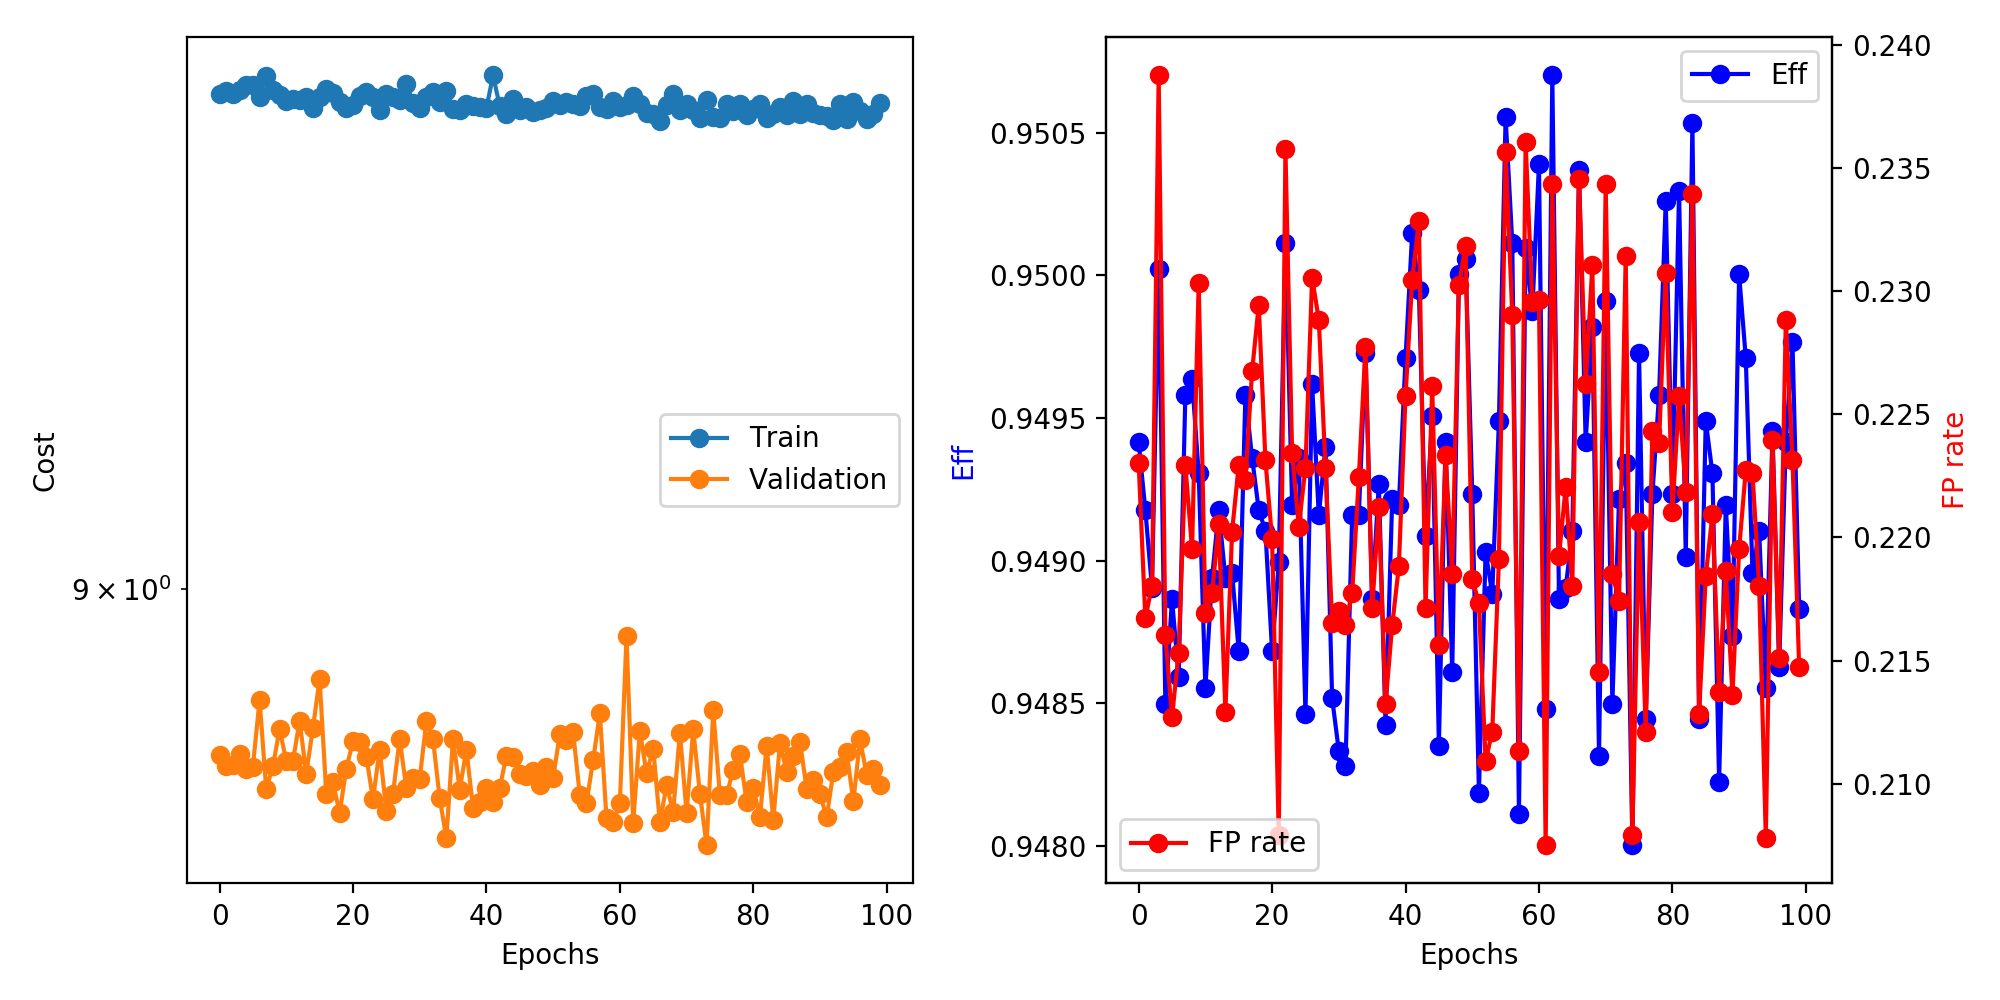

In [19]:
dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [ ]:
quit()